In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")
COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

In [3]:
sys.path.insert(0, "../metapop")

from utils_data_metapop import create_population_data, create_time_transfers

path_to_ward_counts = os.path.join(data_db_dir, "long_files_8_25_2021", "counts_ward.csv" )
path_to_ward_transf = os.path.join(data_db_dir, "long_files_8_25_2021", "transfers_ward.csv" )

A_df, D_df, H_df, tests_df, Hmean_df = create_population_data(path_to_ward_counts)

num_wards  = len(Hmean_df)
ward_names = list(Hmean_df.index)
M_df       = create_time_transfers(path_to_ward_transf, num_wards=num_wards, ward_names=ward_names)


In [4]:
selected_buildings = ['Allen Hospital', 'Harkness Pavilion', 'Milstein Hospital', 'Mschony', 'Presbyterian Hospital', "Rest"]
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}
building2id[5]     = "Rest"

def building2building(building):
    if building in selected_buildings:
        return building
    else:
        return "Rest"


counts_ward_df             = pd.read_csv(path_to_ward_counts, parse_dates=["date"])
counts_ward_df["building"] = counts_ward_df.apply(lambda x: x.ward.split("-")[1], axis=1)
counts_ward_df["building"] = counts_ward_df.apply(lambda x: building2building(x.building), axis=1)

counts_ward_df             = counts_ward_df.reset_index(drop=True)
buildings_df               = counts_ward_df.copy(); buildings_df = buildings_df.groupby(['date', 'building']).sum().reset_index()

date_start    = pd.to_datetime('2020-02-01')
date_end      = pd.to_datetime('2021-02-28')
dates         = pd.date_range(date_start, date_end)
Tdat          =  len(dates)

buildings_df  = buildings_df[buildings_df.date.isin(dates)]

A     = pd.pivot(buildings_df, index='building', columns='date', values='num_admitted')
D     = pd.pivot(buildings_df, index='building', columns='date', values='num_discharged')
H     = pd.pivot(buildings_df, index='building', columns='date', values='num_hospitalized')
tests = pd.pivot(buildings_df, index='building', columns='date', values='num_tested')

pop                     = H.mean(axis=1)
num_pop                 = len(pop)

building_names = pop.index

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_40224/1438482836.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  buildings_df               = counts_ward_df.copy(); buildings_df = buildings_df.groupby(['date', 'building']).sum().reset_index()


In [5]:
buildings_df["building2"] = buildings_df.apply(lambda x: building2building(x.building), axis=1)
buildings_plt_df          = buildings_df.groupby(['date', 'building2']).sum().reset_index()
hosp_df                   = buildings_plt_df.groupby(['date']).sum().reset_index()


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_40224/2188095908.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  buildings_plt_df          = buildings_df.groupby(['date', 'building2']).sum().reset_index()
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_40224/2188095908.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_df                   = buildings_plt_df.groupby(['date']).sum().reset_index()


In [6]:
def corr_lag(df, col1="num_admitted", col2="num_discharged", lags=np.arange(-20, 0)):
    corr = np.full(len(lags), np.nan)

    for idx_l, lag in enumerate(lags):
        df_lag       = df.copy()
        df_lag[col2] = df_lag[col2].shift(periods=lag)
        corr[idx_l]  = df_lag.corr().loc[col1][col2]

    return pd.DataFrame({"lag": lags, "correlation": corr})

hosp_df             = pd.read_csv(path_to_ward_counts, parse_dates=["date"])
hosp_df["building"] = hosp_df["ward"].map(lambda x: building2building(x.split("-")[1]))


In [7]:
corr_df                  = corr_lag(hosp_df.drop(columns=["ward"]).groupby(["date"]).sum(), col1="num_admitted", col2="num_discharged", lags=np.arange(-20, 0+1))
corr_df["spatial_scale"] = "hospital"


lag_resume_df = pd.DataFrame(columns=["lag_max", "corr_max", "spatial_scale", "building", "ward"])

for building in selected_buildings:
    b_df                   = hosp_df[hosp_df.building==building].groupby(["date"])[["num_admitted", "num_discharged"]].sum()

    cb_df                  = corr_lag(b_df, col1="num_admitted", col2="num_discharged", lags=np.arange(-20, 0+1))
    cb_df["spatial_scale"] = "building"
    cb_df["building"]      = building
    lag_max                = cb_df.lag[np.argmax(cb_df.correlation)]
    corr_max               = np.max(cb_df.correlation)

    lag_resume_df = pd.concat([lag_resume_df, pd.DataFrame({"lag_max": [lag_max], "corr_max": [corr_max],
                                                            "spatial_scale": ["building"], "building": [building] })])
    corr_df        = pd.concat([corr_df, cb_df])

for ward in hosp_df.ward.unique():
    w_df                   = hosp_df[hosp_df.ward==ward].groupby(["date"])[["num_admitted", "num_discharged"]].sum()
    cw_df                  = corr_lag(w_df, col1="num_admitted", col2="num_discharged", lags=np.arange(-20, 0+1))
    cw_df["spatial_scale"] = "ward"
    cw_df["building"]      = building2building(ward.split("-")[1])
    cw_df["ward"]          = ward

    if np.argmax(cw_df.correlation)!=-1:
        lag_max  = cw_df.lag[np.argmax(cw_df.correlation)]
        corr_max = np.max(cw_df.correlation)
        lag_resume_df = pd.concat([lag_resume_df, pd.DataFrame({"lag_max": [lag_max], "corr_max": [corr_max],
                                                                "spatial_scale": ["ward"], "ward": [ward],
                                                                "building": [building2building(ward.split("-")[1])]
                                                                })])

    corr_df       = pd.concat([corr_df, cw_df])




/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_40224/3578076881.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  corr_df                  = corr_lag(hosp_df.drop(columns=["ward"]).groupby(["date"]).sum(), col1="num_admitted", col2="num_discharged", lags=np.arange(-20, 0+1))


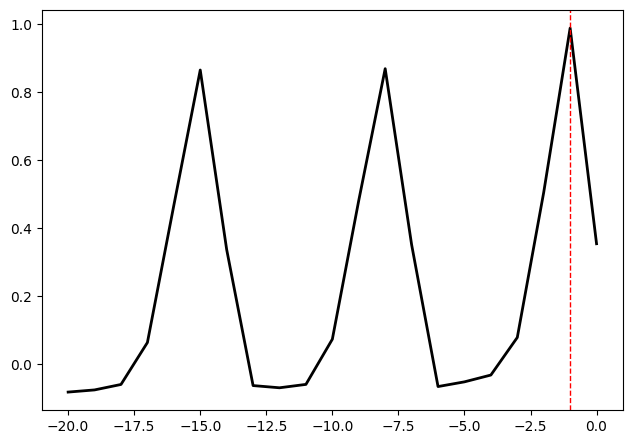

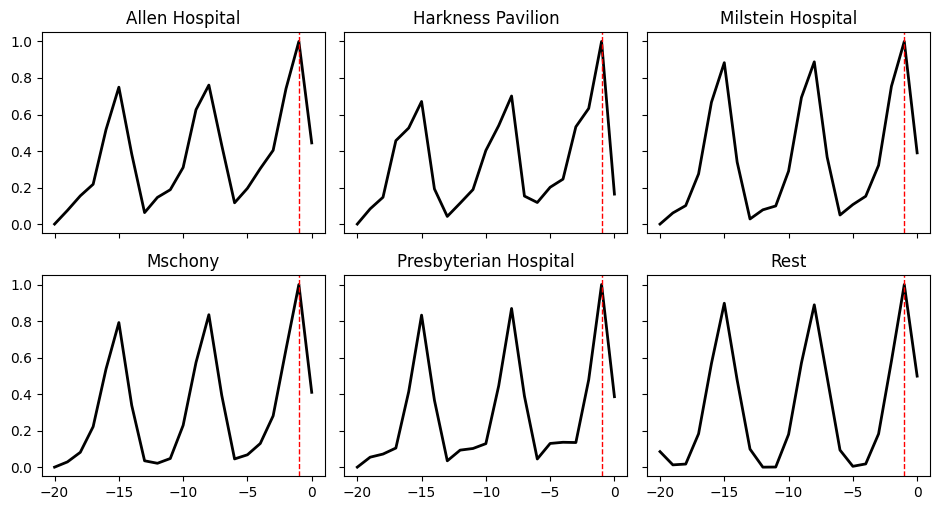

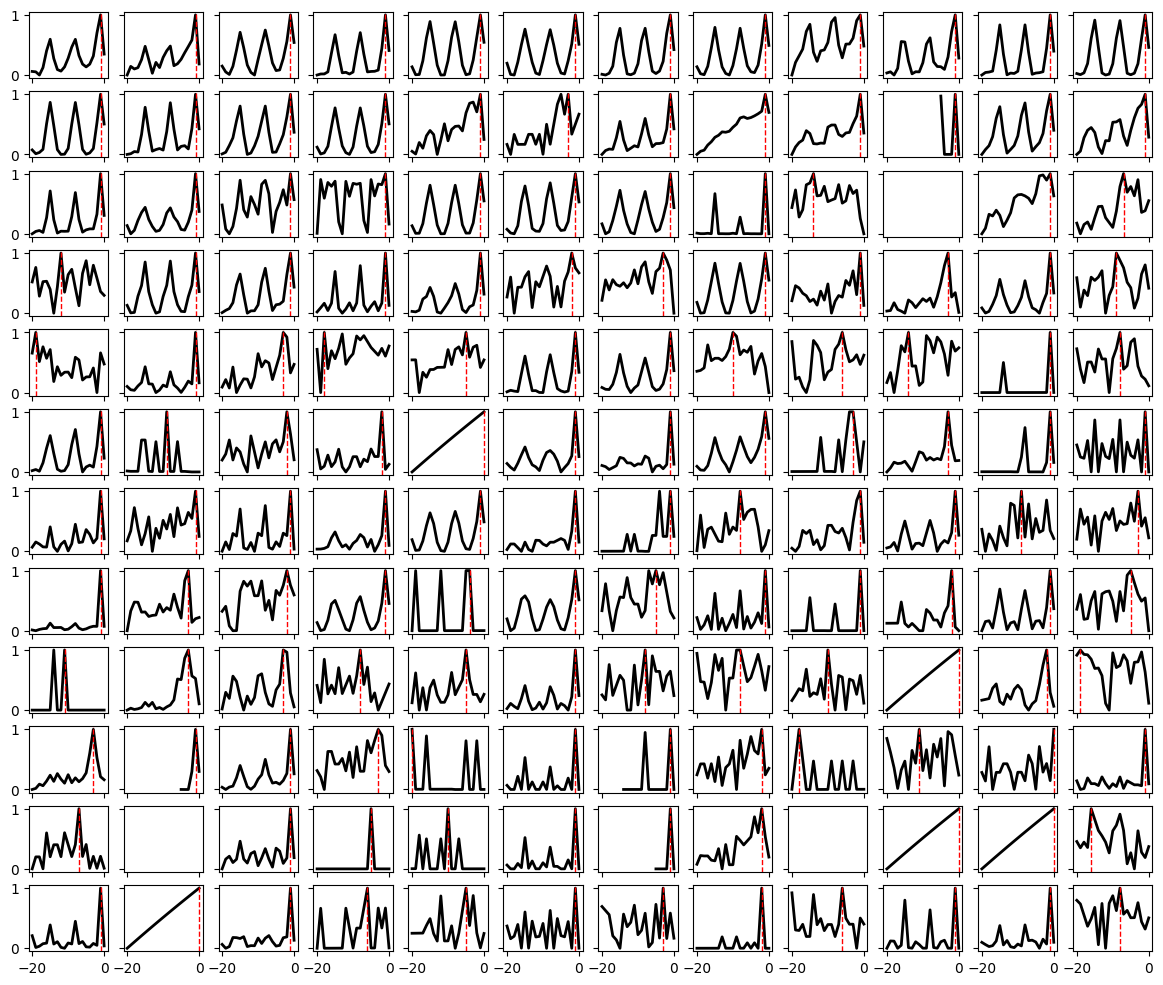

In [8]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.2))
ax.plot(corr_df[corr_df.spatial_scale=="hospital"].lag,
            corr_df[corr_df.spatial_scale=="hospital"].correlation, color="k", lw=2)

lag_max   = corr_df[corr_df.spatial_scale=="hospital"].lag[np.argmax(corr_df[corr_df.spatial_scale=="hospital"].correlation)]
ax.axvline(x=lag_max, color="r", linestyle="--", lw=1)


fig, axes = plt.subplots(2, 3, figsize=(9.5, 5.2), sharex=True, sharey=True)
for idx_ax, ax in enumerate(axes.flatten()):
    bc_df     = corr_df[corr_df.spatial_scale=="building"]
    bc_df     = bc_df[bc_df.building==selected_buildings[idx_ax]]
    norm_corr = bc_df.correlation - np.min(bc_df.correlation)
    norm_corr = norm_corr/(np.max(bc_df.correlation)-np.min(bc_df.correlation))

    ax.plot(bc_df.lag, norm_corr, color="k", lw=2)
    ax.set_title(selected_buildings[idx_ax])

    lag_max = bc_df.lag[np.argmax(norm_corr)]
    ax.axvline(x=lag_max, color="r", linestyle="--", lw=1)
plt.tight_layout()

wards     = hosp_df.ward.unique()

fig, axes = plt.subplots(12, 12, figsize=(14.5, 12.2), sharex=True, sharey=True)
for idx_ax, ax in enumerate(axes.flatten()):
    wc_df    = corr_df[corr_df.ward==wards[idx_ax]]
    norm_corr = wc_df.correlation - np.min(wc_df.correlation)
    norm_corr = norm_corr / (np.max(wc_df.correlation)-np.min(wc_df.correlation))

    ax.plot(wc_df.lag, norm_corr, color="k", lw=2)
    if np.argmax(norm_corr)!=-1:
        lag_max = wc_df.lag[np.argmax(norm_corr)]
        ax.axvline(x=lag_max, color="r", linestyle="--", lw=1)


	 Average LOS for Allen Hospital: 3.17
	 Average LOS for Harkness Pavilion: 4.38
	 Average LOS for Milstein Hospital: 6.22
	 Average LOS for Mschony: 5.05
	 Average LOS for Presbyterian Hospital: 1.25
	 Average LOS for Rest: 1.85


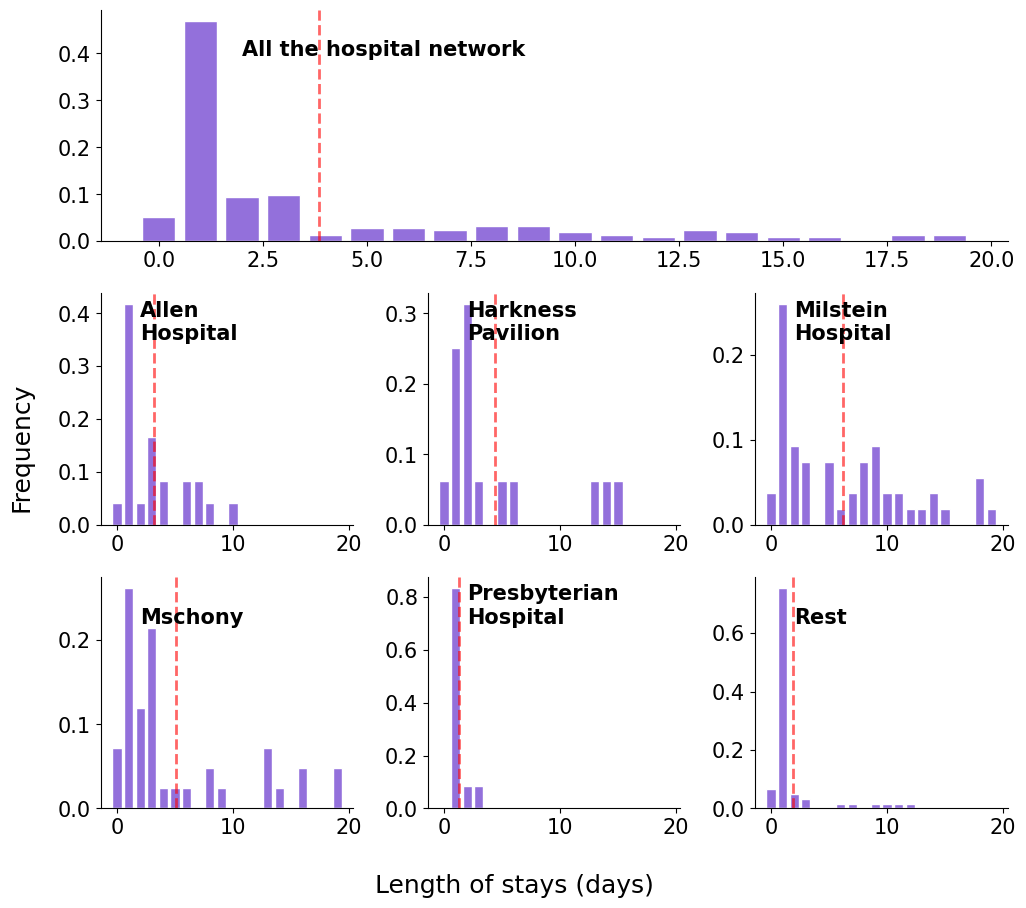

In [30]:
from utils_local import plot_utils

layout = [["hospital", "hospital", "hospital"],
          [selected_buildings[0], selected_buildings[1], selected_buildings[2]],
          [selected_buildings[3], selected_buildings[4], selected_buildings[5]]]

fig, axes = plt.subplot_mosaic(layout,
                                figsize=(10.5, 9.2),
                                sharex=False, sharey=False)

count, bins = np.histogram(-lag_resume_df["lag_max"], bins=np.arange(0, 20+1))
axes["hospital"].bar(bins[:-1], count/count.sum(), facecolor="mediumpurple", edgecolor="w", width=0.8)
axes["hospital"].spines['right'].set_visible(False)
axes["hospital"].spines['top'].set_visible(False)
axes["hospital"].text(x              = 2,
            y          = axes["hospital"].get_ylim()[1] - axes["hospital"].get_ylim()[1]/5,
            s          = "All the hospital network",
            fontweight = "bold")

axes["hospital"].axvline(x=-lag_resume_df["lag_max"].mean(), color="red", linestyle="--", lw=2, alpha=0.6)

for idx_ax, building in enumerate(selected_buildings):

    lag_b_df    = lag_resume_df[lag_resume_df.building==building]
    lag_b_df    = lag_b_df[lag_b_df.spatial_scale=="ward"]
    count, bins = np.histogram(-lag_b_df["lag_max"], bins=np.arange(0, 20+1))
    axes[building].bar(bins[:-1], count/count.sum(), facecolor="mediumpurple", edgecolor="w", width=0.8)
    axes[building].text(x          = 2,
                        y          = axes[building].get_ylim()[1] - axes[building].get_ylim()[1]/5,
                        s          = building.replace(" ", "\n"),
                        fontweight = "bold")

    axes[building].spines['right'].set_visible(False)
    axes[building].spines['top'].set_visible(False)
    axes[building].axvline(x=-lag_b_df["lag_max"].mean(), color="red", linestyle="--", lw=2, alpha=0.6)

    print("\t Average LOS for {}: {:0.2f}".format(building, -lag_b_df["lag_max"].mean()))

fig.supxlabel(r'Length of stays (days)')
fig.supylabel(r'Frequency')

plt.tight_layout()

